<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#Выбор-Модели" data-toc-modified-id="Выбор-Модели-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Выбор Модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-Вывод" data-toc-modified-id="Общий-Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import fbeta_score, make_scorer
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

import warnings
warnings.filterwarnings("ignore")

In [2]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.index.is_monotonic

True

In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
data.isna().mean()

num_orders    0.0
dtype: float64

### Вывод

- Даны заказы такси с интервалом 10 минут с 2018-03-01 00:00:00 по 2018-08-31 23:50:00
- пропусков нет
- стандартное отклонение 45.
- Всего один признак: колличество заказов. 
- Необходимо создать признаки календарные, скользящие и отстающие значения.

## Анализ

Проведем ресемплирование и отобразим граффик:

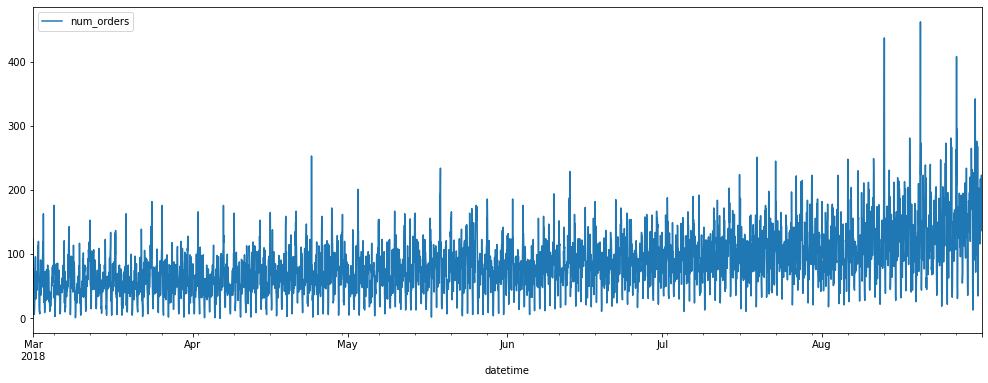

In [6]:
data = data.resample('1H').sum()
figsize = (17, 6)
data.plot(figsize=figsize)
plt.show()

Разложим временной ряд на три составляющие: тренд, сезонность и остаток

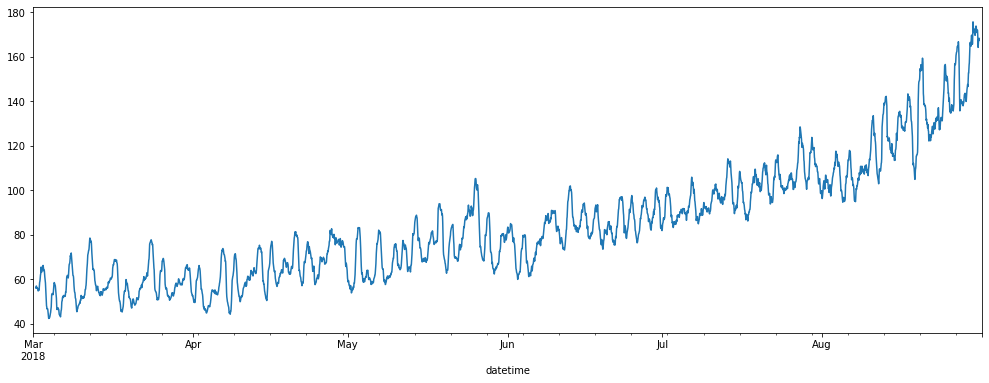

In [7]:
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(figsize=figsize)
plt.show()

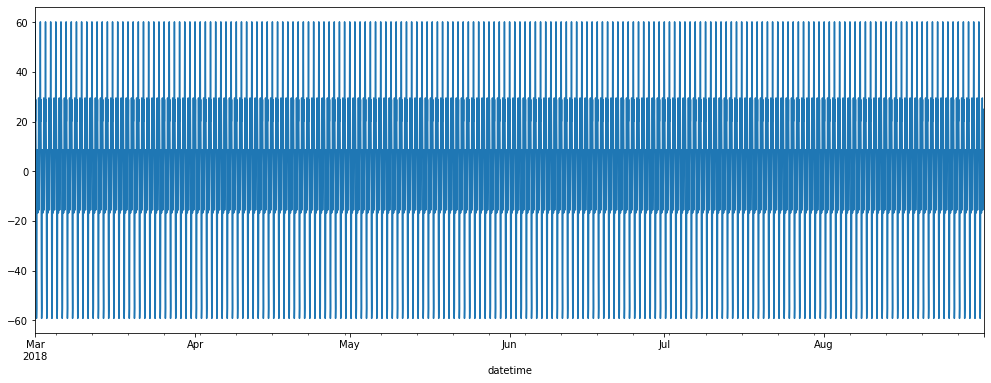

In [8]:
decomposed_data.seasonal.plot(figsize=figsize)
plt.show()

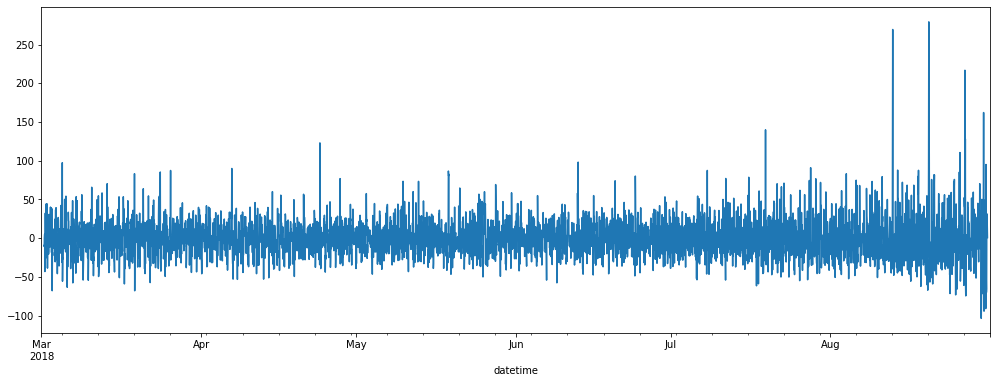

In [9]:
decomposed_data.resid.plot(figsize=figsize)
plt.show()

Разложим последнюю неделю на три составляющие: тренд, сезонность и остаток

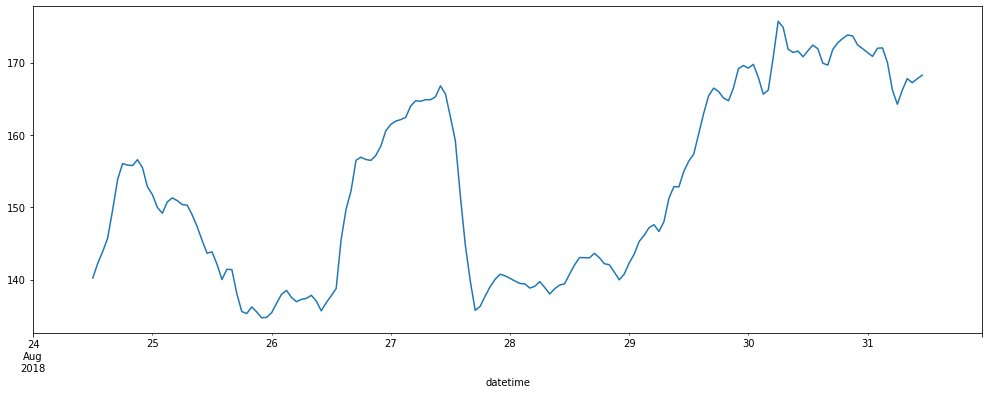

In [10]:
decomposed_data = seasonal_decompose(data['2018-08-24':'2018-08-31'])
decomposed_data.trend.plot(figsize=figsize)
plt.show()

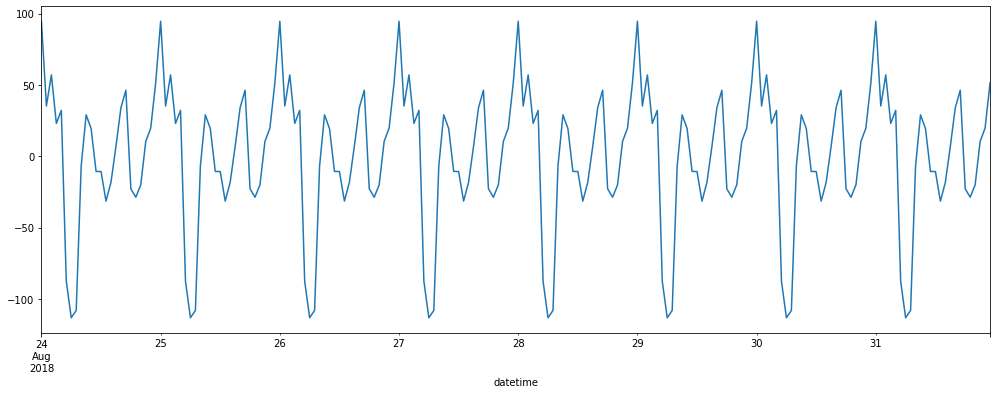

In [11]:
decomposed_data.seasonal.plot(figsize=figsize)
plt.show()

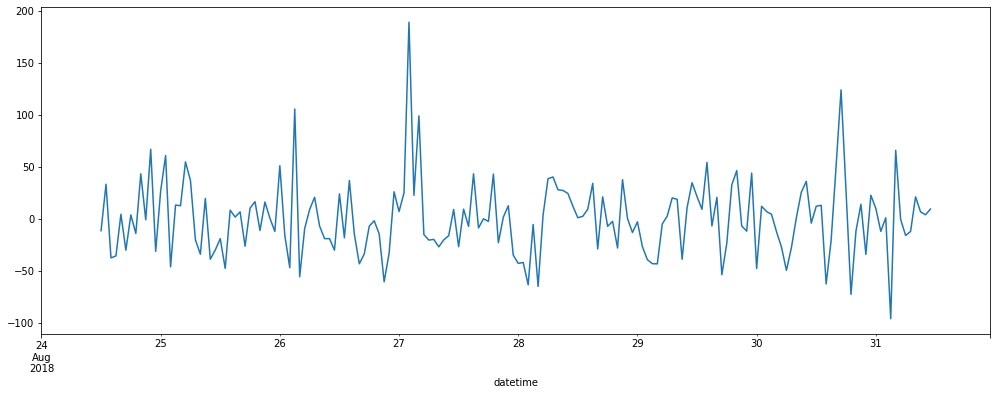

In [12]:
decomposed_data.resid.plot(figsize=figsize)
plt.show()

Создам функцию make_features которая:
- Добавляет фактор месяца и фактор дня исходя из общего тренда
- Добавляет фактор дня недели, так как на графике недели видим большую вариацию добавляет фактор часа, так как прослеживаем пики активности в течении суток Добавляет lag

In [13]:
df = data.copy(deep=True)

In [14]:
def make_features(df, max_lag, rolling_sum_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_sum'] = df['num_orders'].shift().rolling(rolling_sum_size).mean()
    return df

In [15]:
make_features(df, 47, 50)
df.shape

(4416, 53)

In [16]:
df.head(3)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,rolling_sum
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df = df.dropna()

In [18]:
df.shape

(4366, 53)

In [19]:
df.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,rolling_sum
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,3,3,5,2,108.0,163.0,72.0,119.0,101.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,62.82
2018-03-03 03:00:00,64,3,3,5,3,25.0,108.0,163.0,72.0,119.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,60.84
2018-03-03 04:00:00,44,3,3,5,4,64.0,25.0,108.0,163.0,72.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,60.42
2018-03-03 05:00:00,15,3,3,5,5,44.0,64.0,25.0,108.0,163.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,59.88
2018-03-03 06:00:00,9,3,3,5,6,15.0,44.0,64.0,25.0,108.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,58.86
2018-03-03 07:00:00,17,3,3,5,7,9.0,15.0,44.0,64.0,25.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,58.18
2018-03-03 08:00:00,56,3,3,5,8,17.0,9.0,15.0,44.0,64.0,...,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,58.40
2018-03-03 09:00:00,73,3,3,5,9,56.0,17.0,9.0,15.0,44.0,...,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,59.28
2018-03-03 10:00:00,52,3,3,5,10,73.0,56.0,17.0,9.0,15.0,...,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,60.44


- Фактор месяца исходя из общего тренда играет роль ,ибо месяцы лета имеют тренд более высокого роста относительно весенних
- Фактор дня играет также роль так как имеет тенденцию также относительно месяца расти с течением времени
- Фактор дня недели играет одну из самых важных ролей ,ибо данные исходя из него сильно варьируются
- Фактор часа играет самую важную роль ,так как у нас прогнозирование на час вперед также на его фоне выделили сезонность ,где есть очень важные часы пиков и минимумов
- Фактор lag нужен для определения интервала на котором обучается модель из целевого признака исходя из желаемого горизонта (если ресампл на день , а прогноз строим на неделю вперед ,то lag(7)) в нашем случае прогноз на час вперед ,то берем и lag(1)
- Фактор rolling еще более темный лес чел lag ,но в моем понимании это в чем-то схожий признак с lag ,но как агрегирующая его функция также полезная для прогнозирования , его параметр не очень понимаю как подбирается, но в данном коротком прогнозировании думаю ,что также должен быть минимальным и равным 2

**Написана функция для подготовки признаков для будущего обучения модели, где выделены календарные признакми:** 
- год
- месяц
- день
- день недели
- час(так как ресемплинг идет по часам)

**Также добавили и другие признаки:** 
- отстающие значения и скользящее среднее
- со смещением,чтобы не было подсматривания данных

Добавим функцию для вычесления rmse:

In [20]:
def rmse(first_list, second_list):
    return np.sqrt(mean_squared_error(first_list, second_list))

### Вывод

- Из декомпозиции можно отметить, что тренд указывает на увеличение заказов
- Сезоность указывает на высокий спрос на такси в ночное время, потому что в это время не работает общественный транспорт.
- Можно сказать, что стохастический процесс нестационарный

- По тренду видно, что со временем все больше и больше людей пользуется услугой заказа такси.
- Спрос высокий в понедельник и увеличивается со среды по пятницу, выходные дни менее активны.
- При разложении по последней неделе видно, что имеются пиковые часы и больше всего такси используется в ночное время и дальше спрос максимально спадает под утро.

## Обучение

### Linear Regression

Для определения количество lag признаков найдем разницу в часах между максимальным пиком и минимальным уровнем в течении 24 часов

In [21]:
day_data = seasonal_decompose(data['2018-08-30':'2018-08-31'])
max_lag = (day_data.seasonal.idxmax() - day_data.seasonal.idxmin()) 

max_lag

Timedelta('0 days 11:00:00')

In [22]:
best_rmse = 99999999
for log in range(47, 50):
    for rsz in range(2, 5):
        find_data = make_features(df, log, rsz)

        data_lr, test = train_test_split(find_data, shuffle=False, test_size=0.1)
        train, valid = train_test_split(data_lr, shuffle=False, test_size=0.25)
        train = train.dropna()
        features_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']

        features_valid = valid.drop('num_orders', axis=1)
        target_valid = valid['num_orders']

        lin_reg = LinearRegression()
        lin_reg.fit(features_train, target_train)

        preds = lin_reg.predict(features_valid)

        current_rmse = rmse(preds, target_valid)
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_rsz = rsz
            best_log = log
print('RMSE:', best_rmse, '\nrolling_sum:', best_rsz, '\nlog:', best_log)

RMSE: 29.60271085268557 
rolling_sum: 4 
log: 48


### CatBoost

In [23]:
model_Cat = CatBoostRegressor( random_state = 42)
hyperparams = [{'depth' : [3],
                'learning_rate' : [0.1],
                'iterations' : [300],
                'verbose' : [False]
               }]
my_cv=TimeSeriesSplit(n_splits=3).split(features_train)
clf = GridSearchCV(model_Cat, hyperparams, cv=my_cv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

print((clf.best_score_*-1)**0.5)

22.143894650060428


In [24]:
best_params_CBR = clf.best_params_
print(best_params_CBR)

{'depth': 3, 'iterations': 300, 'learning_rate': 0.1, 'verbose': False}


Применим функцию make_features на подготовленный датасет. Разделим датасет (тестовая выборка 10%), попробуем разные модели:

In [25]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train.dropna(inplace=True)
test.dropna(inplace=True)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

### LGBMRegressor

In [26]:
LGBMR = LGBMRegressor() 
hyperparams = [{'depth' : [3],
                'learning_rate':[0.03],
                'verbose' : [10],
                'random_state':[42]}]

my_cv=TimeSeriesSplit(n_splits=3).split(features_train)
clf = GridSearchCV(model_Cat, hyperparams, cv=my_cv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

0:	learn: 28.8572111	total: 3.17ms	remaining: 3.17s
10:	learn: 25.7838679	total: 24.7ms	remaining: 2.22s
20:	learn: 23.7237053	total: 47.9ms	remaining: 2.23s
30:	learn: 22.1851353	total: 71.8ms	remaining: 2.24s
40:	learn: 21.0978914	total: 96.3ms	remaining: 2.25s
50:	learn: 20.2126191	total: 120ms	remaining: 2.23s
60:	learn: 19.5735164	total: 142ms	remaining: 2.18s
70:	learn: 19.0930933	total: 160ms	remaining: 2.09s
80:	learn: 18.6849012	total: 178ms	remaining: 2.02s
90:	learn: 18.3525404	total: 200ms	remaining: 2s
100:	learn: 18.0719955	total: 225ms	remaining: 2s
110:	learn: 17.8294818	total: 250ms	remaining: 2s
120:	learn: 17.5769506	total: 270ms	remaining: 1.96s
130:	learn: 17.3692601	total: 289ms	remaining: 1.92s
140:	learn: 17.2259343	total: 308ms	remaining: 1.88s
150:	learn: 17.0799409	total: 327ms	remaining: 1.84s
160:	learn: 16.9764045	total: 346ms	remaining: 1.8s
170:	learn: 16.8503256	total: 366ms	remaining: 1.77s
180:	learn: 16.7324506	total: 385ms	remaining: 1.74s
190:	lear

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f9030126f20>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f90301322b0>,
             param_grid=[{'depth': [3], 'learning_rate': [0.03],
                          'random_state': [42], 'verbose': [10]}],
             scoring='neg_mean_squared_error')

In [27]:
print(clf.best_params_)
print((clf.best_score_*-1)**0.5)

{'depth': 3, 'learning_rate': 0.03, 'random_state': 42, 'verbose': 10}
25.338324851037147


### XGBoost

In [28]:
modelXGB = XGBRegressor(random_state = 42)
param_search = {'max_depth' : [3],
                'learning_rate' : [0.1],
                'n_estimators' : [500]
               }
tscv = TimeSeriesSplit(n_splits=5)
gsearchXGB = GridSearchCV(estimator=modelXGB, cv=tscv,
                        param_grid=param_search,scoring = 'neg_root_mean_squared_error')
gsearchXGB.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth...
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=42, reg_alpha=None,
                                    reg_l

In [29]:
gsearchXGB.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

In [30]:
np.abs(gsearchXGB.best_score_)

24.309807323099264

## Тестирование

### Linear Regression

43.242912765340634


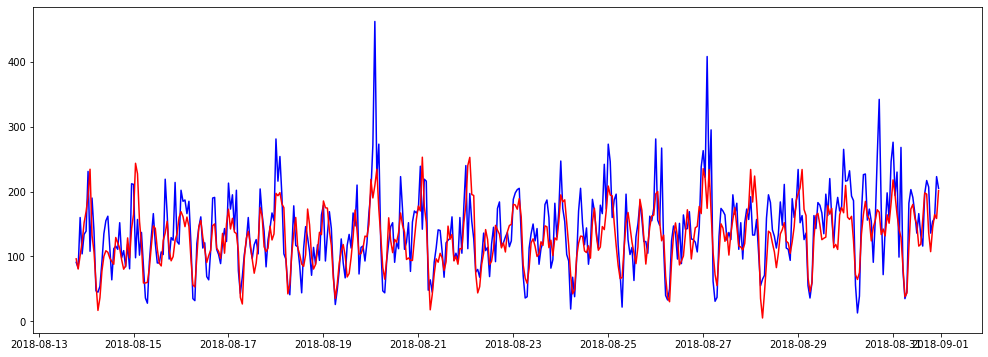

In [31]:
model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
rmse_lr = mean_squared_error(target_test, target_predict) ** 0.5
print(rmse_lr)
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'r-')
plt.show()

### CatBoost

41.18395579510713


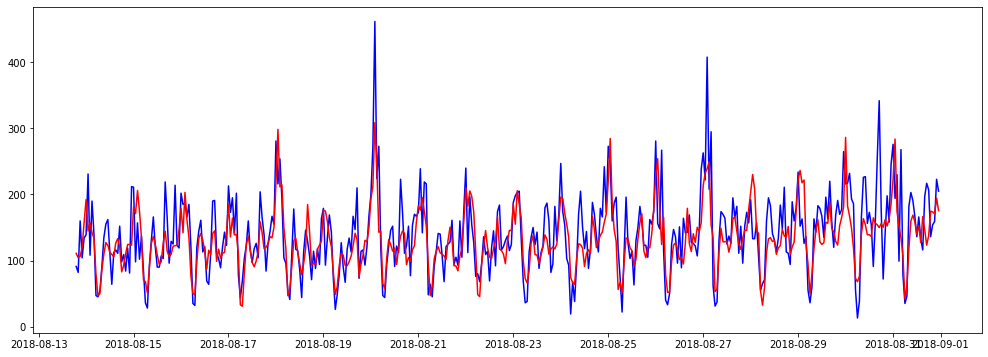

In [32]:
modelCat = CatBoostRegressor(depth = 3, iterations = 300, learning_rate = 0.1, verbose= False)
modelCat.fit(features_train, target_train)
modelCat_predict = modelCat.predict(features_test)
rmse_cbr = mean_squared_error(target_test, modelCat_predict) ** 0.5
print(rmse_cbr)
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, modelCat_predict,'r-')
plt.show()

### LGBMRegressor

In [33]:
model_XGB = XGBRegressor(depth = 3, learning_rate = 0.03, random_state = 42)
LGBMR.fit(features_train, target_train)
target_predict = LGBMR.predict(features_test)
rmse_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

In [34]:
print(rmse_LGBMR)

40.61008196037175


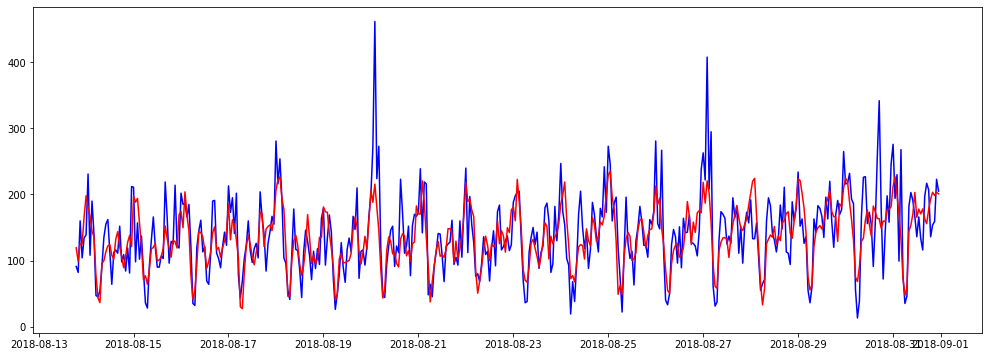

In [35]:
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'r-')
plt.show()

### XGBoost

In [36]:
modelXGB = XGBRegressor(max_depth = 3, n_estimators = 500, learning_rate = 0.03,random_state = 42)
modelXGB.fit(features_train, target_train, eval_set = [(features_train, target_train),(features_test, target_test)], eval_metric = 'rmse', verbose = 10);
rmse_XGB = mean_squared_error(target_test, modelXGB.predict(features_test))**0.5

[0]	validation_0-rmse:85.08285	validation_1-rmse:147.76454
[10]	validation_0-rmse:65.21496	validation_1-rmse:120.10074
[20]	validation_0-rmse:51.05003	validation_1-rmse:99.81606
[30]	validation_0-rmse:41.17746	validation_1-rmse:85.00451
[40]	validation_0-rmse:34.43241	validation_1-rmse:73.59846
[50]	validation_0-rmse:29.91460	validation_1-rmse:65.06866
[60]	validation_0-rmse:26.98950	validation_1-rmse:59.20127
[70]	validation_0-rmse:25.11887	validation_1-rmse:54.68997
[80]	validation_0-rmse:23.89516	validation_1-rmse:51.04851
[90]	validation_0-rmse:23.06823	validation_1-rmse:48.21133
[100]	validation_0-rmse:22.45555	validation_1-rmse:46.17456
[110]	validation_0-rmse:22.04352	validation_1-rmse:44.75719
[120]	validation_0-rmse:21.74920	validation_1-rmse:43.77493
[130]	validation_0-rmse:21.49365	validation_1-rmse:43.04885
[140]	validation_0-rmse:21.27979	validation_1-rmse:42.60326
[150]	validation_0-rmse:21.08983	validation_1-rmse:42.28201
[160]	validation_0-rmse:20.91359	validation_1-rms

In [37]:
print(rmse_XGB)

40.96387839218299


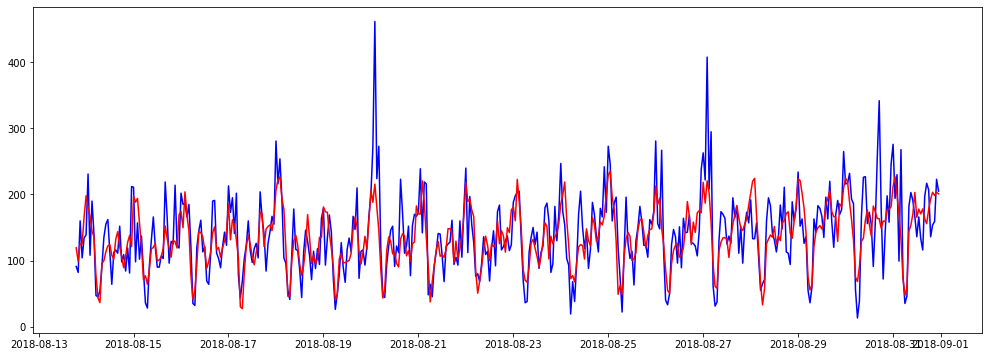

In [38]:
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'r-')
plt.show()

### Выбор Модели

In [39]:
predictive_model_scores = pd.DataFrame(data=[('Linear Regression',rmse_lr), 
                                             ('LGBMRegressor', rmse_LGBMR),
                                            ('CatBoost',rmse_cbr),
                                             ('XGBoost',rmse_XGB)],
                                       columns=['model', 'testing_rmse'])
predictive_model_scores

,model,testing_rmse
0,Linear Regression,43.242913
1,LGBMRegressor,40.610082
2,CatBoost,41.183956
3,XGBoost,40.963878


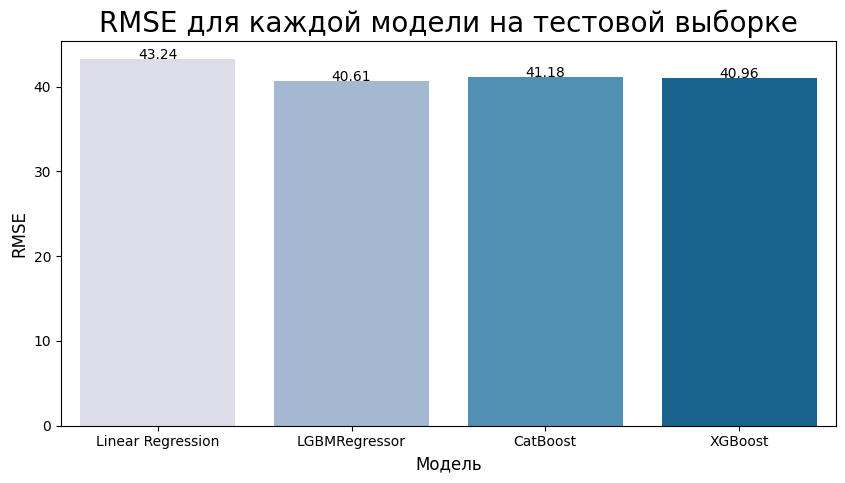

In [40]:
plt.style.use('default')
plt.figure(figsize=(10,5))
p=sns.barplot(x='model', y='testing_rmse', data=predictive_model_scores, palette='PuBu')
plt.title('RMSE для каждой модели на тестовой выборке', fontsize = 20)
plt.xlabel('Модель', fontsize = 12)
plt.ylabel('RMSE', fontsize = 12)
for index, row in predictive_model_scores.iterrows():
    p.text(x=row.name, y=row.testing_rmse, s=round(row.testing_rmse,2), color='black', horizontalalignment='center');

### Вывод

Обученные модели дали следующие результаты:
- Linear Regression:
   - rmse_train - 29.6027
   - rmse_test - 43.2429
- CatBoost:
  - rmse_train - 22.1438
  - rmse_test - 41.1839
- XGBoost:
  - rmse_train - 24.3098
  - rmse_test - 40.9638
- LGBMRegressor:
  - rmse_train - 25.3383
  - rmse_test - 40.6100
  
Немного смутило очень малое значение и такая большая разница на тестовой выборке, но возможно это специфика временных рядов(или специального вида кросс валидации для временных рядов). Ведь мы пытались сделать их более стационарными, но по графикам мне кажется, что удалось сделать это только со средним значением. Стандартное отклонение не так сильно и изменилось(если честно, не вижу вообще сущесвтенной разницы).

## Общий Вывод

Значение метрики RMSE на лучшей модели на тестовой выборке не превышает указанного в задании 48 у всех моделей. Однако, лучшая модель - это LGBMRegressor (rmse_test - 40.6100). 